import torch
torch.cuda.empty_cache() # PyTorch thing
import gc

!gpustat -cp


from numba import cuda
cuda.select_device(0)
cuda.close()

In [16]:
import numpy as np
import importlib

In [17]:
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
from torch.utils.data import DataLoader

In [18]:
import torch.nn.functional as F
import os

In [19]:
import torchvision.models as models

In [33]:
import custom_modules
importlib.reload(custom_modules.helper_fns)
importlib.reload(custom_modules.critic)
importlib.reload(custom_modules.generator_2)
importlib.reload(custom_modules.FID_helpers)

from custom_modules.generator_2 import Generator
from custom_modules.critic import Critic
from custom_modules.FID_helpers import frechet_distance
from custom_modules.FID_helpers import get_covariance
from custom_modules.FID_helpers import matrix_sqrt
from custom_modules.FID_helpers import preprocess
from custom_modules.helper_fns import show_tensor_images


In [ ]:
#!cp -r 500-imgs/real direct/

In [23]:
trans=transforms.Compose([
    transforms.ToTensor()
])
dataset=torchvision.datasets.ImageFolder(root='direct/',transform=trans)

In [24]:
print(len(dataset))

502


In [44]:
train_dataloader=DataLoader(dataset,batch_size=16,num_workers=4,pin_memory=True)

torch.Size([16, 3, 218, 178])
16


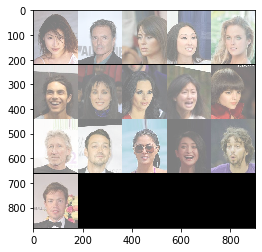

In [45]:
x=next(iter(train_dataloader))
print(x[0].shape)
print(len(x[0]))

show_tensor_images(x[0])

In [28]:
#os.environ['TORCH_HOME'] = 'pretrained_feture_mdls/vgg_16/' #setting the environment variable
vgg_m=models.vgg16(pretrained=False)
vgg_m.load_state_dict(torch.load('pretrained_feture_mdls/vgg_16/checkpoints/vgg16-397923af.pth'))
vgg_m.classifier[6]=torch.nn.Identity()
vgg_m.fc=torch.nn.Identity()


In [49]:
#vgg_m

In [73]:
from PIL import Image

img=Image.open('500-imgs/real/img0.jpg')
img=transforms.ToTensor()(img)
#img=transforms.ToPILImage()(img)
img=F.interpolate(img.unsqueeze(0),size=(60,70))
print(img.grad)
#img=img.resize(size=(60,70))
#img=transforms.ToTensor()(img)
#outt=gen(img.unsqueeze(0))
#show_tensor_images(outt)

None


* Loading the helper functions

In [51]:
import custom_modules.helper_fns
import custom_modules.critic
import custom_modules.generator
import custom_modules.FID_helpers
from custom_modules.helper_fns import CustomDataset2
from custom_modules.helper_fns import get_crit_loss
from custom_modules.helper_fns import get_gen_loss
from custom_modules.helper_fns import get_gradient
from custom_modules.helper_fns import gradient_penalty
from custom_modules.helper_fns import show_tensor_images


In [52]:
from custom_modules.generator import Generator

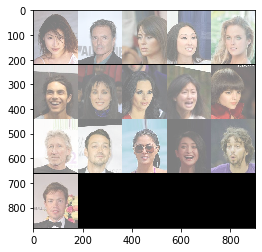

ValueError: pic should be 2/3 dimensional. Got 4 dimensions.

In [70]:
device='cuda'
lr=0.0002
beta_1=0.3
beta_2=0.8
c_lambda=0.2

device='cuda'
#gen = Generator(input_shape=(20,3,70,60)).to(device)
gen=torch.load('model_saving/models/first_upsampled9.pb')
gen.to(device)
gen.train()
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
crit = Critic().to(device) 
crit_opt = torch.optim.Adam(crit.parameters(), lr=lr, betas=(beta_1, beta_2))


vgg_m.to(device)
n_epochs=10
crit_repeats=5
generator_losses = []
critic_losses = []
for epoch in range(n_epochs):
    
    mean_iteration_critic_loss=0
    for i,batch in enumerate(train_dataloader):
        gen_opt.zero_grad()
        super_res=batch[0]
        show_tensor_images(super_res)
        
        x=transforms.ToPILImage()(super_res)
        crap=x.resize(size=(60,70))
        #crap=F.interpolate(super_res,size=(60,70))
        #crap=crap.to(device)
        show_tensor_images(crap)
        
        for _ in range(crit_repeats):
            crit_opt.zero_grad()
            fake = gen(crap)
            # TO delete
            #show_tensor_images(fake)
            # -------------#
            crit_fake_pred = crit(fake.detach())
            #print(crit_fake_pred.shape)
            crit_real_pred = crit(super_res.to(device))

            epsilon = torch.rand(len(super_res), 1, 1, 1, device=device, requires_grad=True)
            gradient = get_gradient(crit, super_res, fake.detach(), epsilon.to('cuda'))
            gp = gradient_penalty(gradient)
            crit_loss = get_crit_loss(crit_fake_pred, crit_real_pred, gp, c_lambda)

            #mean_iteration_critic_loss += crit_loss.item() / crit_repeats
            # Update gradients
            crit_loss.backward(retain_graph=True)
            # Update optimizer
            crit_opt.step()
            #critic_losses += [mean_iteration_critic_loss]
        
        # Now generator
       
        gen_opt.zero_grad()
        fake_2 = gen(crap)
        # To Delete
        #show_tensor_images(fake_2)
        # ---------
        crit_fake_pred = crit(fake_2)
        
        gen_loss = get_gen_loss(crit_fake_pred)
        gen_loss.backward()

        # Update the weights
        gen_opt.step()

        # Keep track of the average generator loss
        generator_losses += [gen_loss.item()]

        
        
        
        #------------for FID monitoring-------------
        fake_features_list = []
        super_res_features_list = []
        
        '''
        for i in range(len(batch[0])):
            super_res_features = vgg_m(super_res[i].unsqueeze(0).to(device)).detach().to('cpu') # Move features to CPU
            super_res_features_list.append(super_res_features)

            fake_samples = preprocess(gen(crap[i].unsqueeze(0)))
            fake_features = vgg_m(fake_samples.to(device)).detach().to('cpu')
            fake_features_list.append(fake_features) 
        fake_features_all = torch.cat(fake_features_list)
        super_res_features_all = torch.cat(super_res_features_list)
        mu_fake = torch.mean(fake_features_all, dim=0)
        mu_real = torch.mean(super_res_features_all, dim=0)
        sigma_fake = get_covariance(fake_features_all)
        sigma_real = get_covariance(super_res_features_all)
        
        with torch.no_grad():
            loss=frechet_distance(mu_real, mu_fake, sigma_real, sigma_fake).item()
            
        '''
        #loss=np.array(loss)
        #loss=torch.tensor(loss,requires_grad=True)
        #loss.backward()
        #gen_opt.step()
        fake_2=gen(crap)
        
        #print(f"Epoch {epoch} : fid loss: {loss},")
        show_tensor_images(fake_2)
        show_tensor_images(super_res)
